# Titanic usando SVM

Aplicando o algoritmo SVM para resolver o desafio Titanic.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


---------------------------

## 1. Tratamento preliminar dos dados

Vamos considerar que as variáveis 'Name' e 'Ticket' não influenciam na resposta, portanto essas colunas serão excluídas desde já.

In [2]:
df_train.drop(['Name', 'Ticket'], axis=1, inplace=True)
df_test.drop(['Name', 'Ticket'], axis=1, inplace=True)

As variáveis categóricas 'Sex' e 'Embarked' devem ser transformadas em inteiras:

In [3]:
sex = pd.get_dummies(df_train['Sex'],drop_first=True) 
embark = pd.get_dummies(df_train['Embarked'],drop_first=True)
df_train.drop(['Sex', 'Embarked'], axis=1, inplace=True)
df_train = pd.concat([df_train,sex,embark],axis=1)

In [4]:
sex = pd.get_dummies(df_test['Sex'],drop_first=True)
embark = pd.get_dummies(df_test['Embarked'],drop_first=True)
df_test.drop(['Sex', 'Embarked'], axis=1, inplace=True)
df_test = pd.concat([df_test,sex,embark],axis=1)

### 1.1 Lidando com dados ausentes

Vamos agorar analisar os dados ausentes.

<AxesSubplot:>

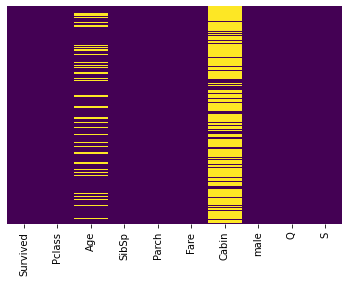

In [5]:
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Existe um grande número de dados de Cabine faltando, por isso essa coluna será ignorada. A idade, no entanto, é importante, e por isso é necessário estabelecer uma estratégia para que os valores sejam preenchidos.

Analisando a relação entre SibSp e Age:

<AxesSubplot:xlabel='SibSp', ylabel='Age'>

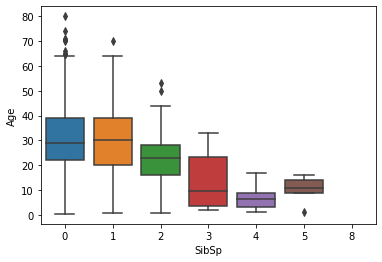

In [15]:
sns.boxplot(x='SibSp', y = 'Age', data=df_train)

Vamos substituir as idades faltantes pela média do SibSp correspondente.

Primeiro vamos obter a média para cada valor de 'SibSp':

In [26]:
print(df_train[df_train['SibSp'] == 0].mean()['Age'])
print(df_train[df_train['SibSp'] == 1].mean()['Age'])
print(df_train[df_train['SibSp'] == 2].mean()['Age'])
print(df_train[df_train['SibSp'] == 3].mean()['Age'])
print(df_train[df_train['SibSp'] == 4].mean()['Age'])
print(df_train[df_train['SibSp'] == 5].mean()['Age'])
print(df_train[df_train['SibSp'] == 8].mean()['Age'])

31.39755838641189
30.089726775956283
22.62
13.916666666666666
7.055555555555555
10.2
nan


/tmp/ipykernel_128842/3311733361.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df_train[df_train['SibSp'] == 0].mean()['Age'])
/tmp/ipykernel_128842/3311733361.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df_train[df_train['SibSp'] == 1].mean()['Age'])
/tmp/ipykernel_128842/3311733361.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(df_train[df_train['SibSp'] == 2].mean()['Age'])
/tmp/ipykernel_128842/3311733361.py:4: FutureWarning: Dropping of nuisanc

Agora vamos montar uma função que imputa os valores de idade:

In [5]:
def impute_age(cols):
    Age = cols[0]
    SibSp = cols[1]
    
    if pd.isnull(Age):

        if SibSp == 0:
            return 31

        elif SibSp == 1:
            return 30
        
        elif SibSp == 2:
            return 23
        
        elif SibSp == 3:
            return 14
        
        elif SibSp == 4:
            return 7

        else:
            return 10

    else:
        return Age
    

df_train['Age'] = df_train[['Age','SibSp']].apply(impute_age,axis=1)
df_train.drop('Cabin', axis=1, inplace=True)
df_train.dropna(inplace=True)

df_test['Age'] = df_test[['Age','SibSp']].apply(impute_age,axis=1)
df_test.drop('Cabin', axis=1, inplace=True)


-------------------------------------------------
## 2. Implementando o modelo

Nesse teste será utilizado Support Vector Machines. Os parâmetros ótimos serão determinados por meio de GridSearch.


In [6]:
X_train = df_train[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'male', 'Q', 'S']]
y_train = df_train['Survived']

In [7]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

Os parâmetros que serão utilizados serão: 

kernel = rbf e poly \
C = 1, 10, 100 \
degree = 2, 3, 4 \

In [80]:
params = {'kernel': ('rbf', 'poly'), 'C': [1, 10, 100], 'degree': [2, 3, 4, 5]}

In [81]:
svc = SVC()

clf = GridSearchCV(svc, params)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'degree': [2, 3, 4, 5],
                         'kernel': ('rbf', 'poly')})

Agora vamos construir um DataFrame com os resultados do Grid Search para visualizar melhor:

In [114]:
results = pd.DataFrame(clf.cv_results_)
results[results['rank_test_score'] == 1][['param_C', 'param_kernel']]

,param_C,param_kernel
16,100,rbf
18,100,rbf
20,100,rbf
22,100,rbf


Nota-se que o melhor kernel é o RBF e o melhor valor de C é 100.

Agora vamos prever os dados de treino com o modelo clf que acabamos de criar e depois vamos avalia-lo:

In [82]:
pred = clf.predict(X_train)

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_train, pred))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       549
           1       0.75      0.74      0.74       342

    accuracy                           0.80       891
   macro avg       0.79      0.79      0.79       891
weighted avg       0.80      0.80      0.80       891



Por fim, vamos prever os valores finais.

Primeiro, vamos conferir o conjunto dos dados de teste:

In [8]:
df_test[df_test.isna().any(axis=1)]

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
152,1044,3,60.5,0,0,NaN,1,0,1


Existe um valor faltando em Fare nos dados de teste. O modelo não poderá ser aplicado até que esse dado seja preenchdo. Não é possível excluí-lo porque o número de linhas deve ser total para ser aceito no Kaggle.

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

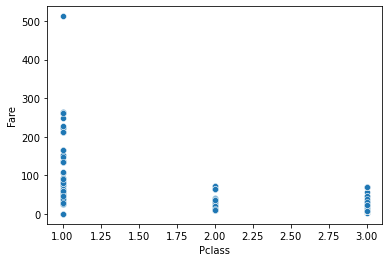

In [100]:
sns.scatterplot(x = 'Pclass', y='Fare', data=df_test)

Vamos preencher o dado faltanta utilizando o valor médio de Fare para Pclass=3:

In [11]:
df_test.fillna(df_test[df_test['Pclass'] == 3].mean()['Fare'], inplace=True)

Por fim, vamos aplicar o modelo e prever os resultados, exportando para um arquivo CSV:

In [122]:
X_test = df_test[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'male', 'Q', 'S']]

pred = clf.predict(X_test)

df_test['Survived'] = pred

In [123]:
df_submission = df_test[['PassengerId', 'Survived']]

df_submission.to_csv(path_or_buf='submission.csv', index=False)